In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt

In [2]:
# https://www.kaggle.com/datasets/vetrirah/customer/data?select=Train.csv
# classification: customer segmentation
# customers from the company’s existing market, so identically distributed
df = pd.read_csv('../data/Train.csv')
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
print('data dimensions:',df.shape)
print('unique IDs:', df['ID'].nunique()) # IDs all unique, can be dropped & datapoints(rows) independent
print(df['Segmentation'].value_counts()) # balanced y

data dimensions: (8068, 11)
unique IDs: 8068
Segmentation
D    2268
A    1972
C    1970
B    1858
Name: count, dtype: int64


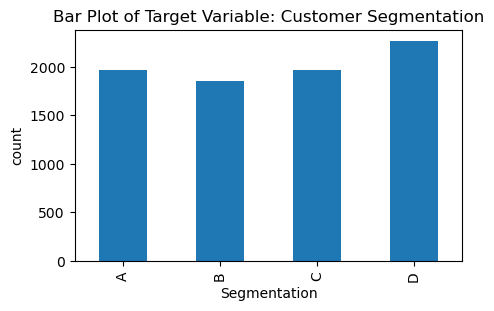

In [4]:
# ppt plot1
plt.figure(figsize=(5,3))
pd.value_counts(df['Segmentation']).loc[['A','B','C','D']].plot.bar()
plt.ylabel('count')
plt.xlabel('Segmentation')
plt.title('Bar Plot of Target Variable: Customer Segmentation')
plt.savefig('../figures/Target Variable',dpi=500,bbox_inches="tight")
plt.show()

Segmentation         A         B         C         D
Gender                                              
Female        0.248973  0.235826  0.252534  0.262668
Male          0.240661  0.225719  0.237265  0.296355


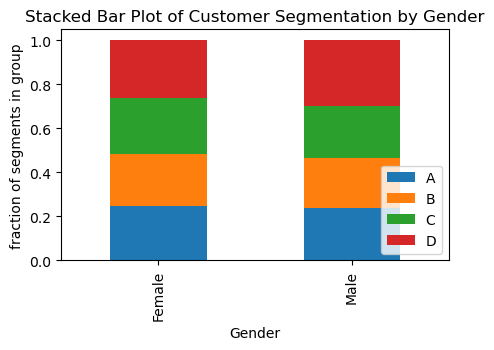

In [5]:
# ppt plot2
count_matrix = df.groupby(['Gender', 'Segmentation']).size().unstack()
# print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print(count_matrix_norm)

count_matrix_norm.plot(kind='bar', stacked=True,figsize=(5,3))
plt.ylabel('fraction of segments in group')
plt.legend(loc=4)
plt.title('Stacked Bar Plot of Customer Segmentation by Gender')
plt.savefig('../figures/Customer Segmentation by Gender',dpi=500,bbox_inches="tight")
plt.show()

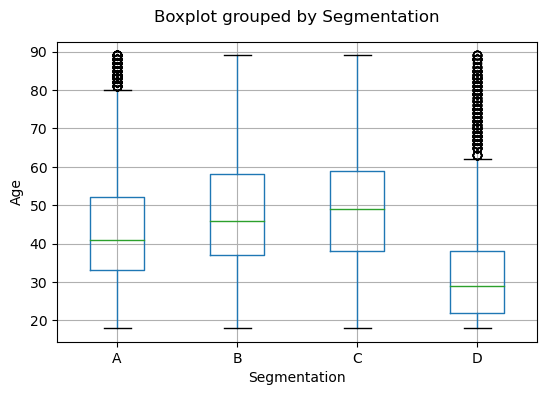

In [6]:
# ppt plot3
df[['Age','Segmentation']].boxplot(by='Segmentation',figsize=(6,4))
plt.ylabel('Age')
plt.xlabel('Segmentation')
plt.title('')
plt.savefig('../figures/Customer Segmentation by Age',dpi=500,bbox_inches="tight")
plt.show()

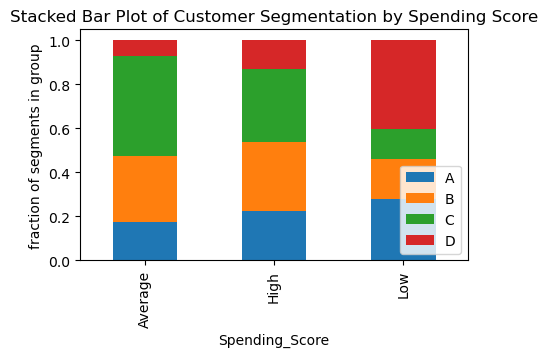

In [7]:
# ppt plot4
count_matrix = df.groupby(['Spending_Score', 'Segmentation']).size().unstack()
# print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
# print(count_matrix_norm)

count_matrix_norm.plot(kind='bar', stacked=True,figsize=(5,3))
plt.ylabel('fraction of segments in group')
plt.legend(loc=4)
plt.title('Stacked Bar Plot of Customer Segmentation by Spending Score')
plt.savefig('../figures/Customer Segmentation by Spending Score',dpi=500,bbox_inches="tight")
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

random_state = 0
X = df.drop(columns=['ID', 'Segmentation'])
y = df['Segmentation']

In [9]:
print('data dimensions:',df.shape)
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('total number of features with missing values:', sum(perc_missing_per_ftr > 0))
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('fraction of points with missing values:',frac_missing)

data dimensions: (8068, 11)
total number of features with missing values: 6
fraction of missing values in features:
Ever_Married       0.017353
Graduated          0.009668
Profession         0.015369
Work_Experience    0.102752
Family_Size        0.041522
Var_1              0.009420
dtype: float64
fraction of points with missing values: 0.1738968765493307


In [10]:
base_acc = y.value_counts()[0] / len(y)
print('baseline accuracy:', base_acc)

baseline accuracy: 0.2811105602379772


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

def MLpipe_KFold_ACC(X, y, ML_algo, param_grid):
    test_scores = []
    best_models = []
    test_sets = []

    nr_states = 5
    for i in range(nr_states):
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state=42*i)
        kf = KFold(n_splits=4, shuffle=True, random_state=42*i)

        cat_ftrs = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1']
        ordinal_ftrs = ['Spending_Score']
        ordinal_cats = [['Low', 'Average', 'High']]
        num_ftrs = ['Age', 'Work_Experience', 'Family_Size']

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
            ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])
        ordinal_transformer = Pipeline(steps=[
            ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
            ('ordinal', OrdinalEncoder(categories = ordinal_cats))])
        numeric_transformer = Pipeline(steps=[
            ('imputer3', IterativeImputer(estimator = LinearRegression(), random_state=42*i)),
            ('scaler', StandardScaler())])
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, num_ftrs),
                ('cat', categorical_transformer, cat_ftrs),
                ('ord', ordinal_transformer, ordinal_ftrs)])
        final_scaler = StandardScaler()

        if 'random_state' in ML_algo.get_params().keys():
            ML_algo.set_params(random_state=42*i)
        clf = ML_algo

        pipe = make_pipeline(preprocessor, final_scaler, clf)
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring = 'accuracy',
                            cv=kf, return_train_score = True, n_jobs=-1) # , verbose=True
        grid.fit(X_other, y_other)
        
        results = pd.DataFrame(grid.cv_results_)
        # save the model
        best_models.append(grid)
        # calculate and save the test score
        y_test_pred = best_models[-1].predict(X_test)
        test_scores.append(accuracy_score(y_test,y_test_pred))

        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_)
        print('test score:',test_scores[i])
        
        test_sets.append([X_test, y_test])

    feature_names = grid.best_estimator_[0].get_feature_names_out()
    print(f"Mean Test Score: {np.mean(test_scores):.4f}")
    print(f"Standard Deviation of Test Scores: {np.std(test_scores):.4f}")

    return test_scores, best_models, test_sets, np.array(feature_names)

In [12]:
from sklearn.linear_model import LogisticRegression
ml_algo = LogisticRegression()
param_grid = {
    'logisticregression__C': np.logspace(-3,1,9),
    'logisticregression__max_iter':[10000]
}
lr = MLpipe_KFold_ACC(X=X, y=y, ML_algo=ml_algo, param_grid=param_grid)

best model parameters: {'logisticregression__C': 1.0, 'logisticregression__max_iter': 10000}
validation score: 0.5017024969827709
test score: 0.5012391573729864
best model parameters: {'logisticregression__C': 3.1622776601683795, 'logisticregression__max_iter': 10000}
validation score: 0.4992253345840142
test score: 0.49814126394052044
best model parameters: {'logisticregression__C': 0.03162277660168379, 'logisticregression__max_iter': 10000}
validation score: 0.49844778829998826
test score: 0.5
best model parameters: {'logisticregression__C': 0.03162277660168379, 'logisticregression__max_iter': 10000}
validation score: 0.5004636276965885
test score: 0.5192069392812887
best model parameters: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 10000}
validation score: 0.49426351952959646
test score: 0.5117719950433705
Mean Test Score: 0.5061
Standard Deviation of Test Scores: 0.0081


In [13]:
print(round((np.mean(lr[0]) - base_acc) / np.std(lr[0]), 3), 'standard deviations above the baseline')

27.769 standard deviations above the baseline


In [14]:
from sklearn.ensemble import RandomForestClassifier

ml_algo = RandomForestClassifier()
param_grid = {
    'randomforestclassifier__n_estimators': [100, 150, 170],
    'randomforestclassifier__max_depth': [9, 10, 11],
    'randomforestclassifier__max_features': [0.2, 0.3, 0.5],
    'randomforestclassifier__min_samples_leaf': [1, 10]
}

rf = MLpipe_KFold_ACC(X=X, y=y, ML_algo=ml_algo, param_grid=param_grid)

best model parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__n_estimators': 100}
validation score: 0.5405940234663986
test score: 0.5204460966542751
best model parameters: {'randomforestclassifier__max_depth': 9, 'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 100}
validation score: 0.5387369198988086
test score: 0.5359355638166047
best model parameters: {'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__n_estimators': 170}
validation score: 0.5387323105099444
test score: 0.5229244114002478
best model parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__n_esti

In [15]:
print(round((np.mean(rf[0]) - base_acc) / np.std(rf[0]), 3), 'standard deviations above the baseline')

22.683 standard deviations above the baseline


In [16]:
from sklearn.neighbors import KNeighborsClassifier
ml_algo = KNeighborsClassifier()
param_grid = {
    'kneighborsclassifier__n_neighbors': [30, 50, 70, 100, 300]
}
knn = MLpipe_KFold_ACC(X=X, y=y, ML_algo=ml_algo, param_grid=param_grid)

best model parameters: {'kneighborsclassifier__n_neighbors': 70}
validation score: 0.4925634232701923
test score: 0.48946716232961585
best model parameters: {'kneighborsclassifier__n_neighbors': 100}
validation score: 0.4927175497103383
test score: 0.4851301115241636
best model parameters: {'kneighborsclassifier__n_neighbors': 30}
validation score: 0.4933344395866608
test score: 0.48636926889714993
best model parameters: {'kneighborsclassifier__n_neighbors': 50}
validation score: 0.4874475778045635
test score: 0.5216852540272615
best model parameters: {'kneighborsclassifier__n_neighbors': 50}
validation score: 0.49008069119322484
test score: 0.48946716232961585
Mean Test Score: 0.4944
Standard Deviation of Test Scores: 0.0137


In [17]:
print(round((np.mean(knn[0]) - base_acc) / np.std(knn[0]), 3), 'standard deviations above the baseline')

15.528 standard deviations above the baseline


In [18]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

test_scores = []
best_models = []
# test_dataframes = []

nr_states = 5
for i in range(nr_states):
    # Split the data into train, validation, and test sets
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state=42*i)
    X_train, X_val, y_train, y_val = train_test_split(X_other, y_other, test_size=0.5, random_state=42*i)

    # Define preprocessing steps using ColumnTransformer and Pipeline
    cat_ftrs = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1']
    ordinal_ftrs = ['Spending_Score']
    ordinal_cats = [['Low', 'Average', 'High']]
    num_ftrs = ['Age', 'Work_Experience', 'Family_Size']

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore')),
        ('scaler', StandardScaler())])
    ordinal_transformer = Pipeline(steps=[
        ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
        ('ordinal', OrdinalEncoder(categories = ordinal_cats)),
        ('scaler', StandardScaler())])
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs),
            ('cat', categorical_transformer, cat_ftrs),
            ('ord', ordinal_transformer, ordinal_ftrs)])

    X_prep = preprocessor.fit_transform(X_train)
    feature_names = preprocessor.get_feature_names_out()
    df_train = pd.DataFrame(data=X_prep,columns=feature_names)
    y_train = le.fit_transform(y_train)
    df_val = preprocessor.transform(X_val)
    df_val = pd.DataFrame(data=df_val,columns = feature_names)
    y_val = le.transform(y_val)
    df_test = preprocessor.transform(X_test)
    df_test = pd.DataFrame(data=df_test,columns = feature_names)
    y_test = le.transform(y_test)

    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [80, 100, 120],
    }

    clf = XGBClassifier(random_state = 42*i, early_stopping_rounds=50)
    grid = GridSearchCV(clf, param_grid=param_grid, scoring = 'accuracy',
                        return_train_score = True, n_jobs=-1)
    grid.fit(df_train, y_train, eval_set=[(df_val, y_val)], verbose=False)
        
    results = pd.DataFrame(grid.cv_results_)
    # save the model
    best_models.append(grid)
    # calculate and save the test score
    y_test_pred = best_models[-1].predict(df_test)
    test_scores.append(accuracy_score(y_test,y_test_pred))

    print('best model parameters:',grid.best_params_)
    print('validation score:',grid.best_score_)
    print('test score:',test_scores[i])

    # # Combine X_test_df and y_test into a single dataframe
    # test_df_combined = pd.concat([X_test_transformed.reset_index(drop=True), pd.DataFrame(data=y_test, columns=['two_year_recid']).reset_index(drop=True)], axis=1)
    # test_dataframes.append(test_df_combined)

# Print the mean and standard deviation of the test scores
print(f"Mean Test Score: {np.mean(test_scores):.4f}")
print(f"Standard Deviation of Test Scores: {np.std(test_scores):.4f}")

best model parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 80}
validation score: 0.5258852329181367
test score: 0.5117719950433705
best model parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
validation score: 0.5311363909088728
test score: 0.5136307311028501
best model parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 120}
validation score: 0.5171992224062207
test score: 0.5216852540272615
best model parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
validation score: 0.5116183070535436
test score: 0.5396530359355638
best model parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 120}
validation score: 0.5184332925336598
test score: 0.523543990086741
Mean Test Score: 0.5221
Standard Deviation of Test Scores: 0.0099


In [19]:
print(round((np.mean(test_scores) - base_acc) / np.std(test_scores), 3), 'standard deviations above the baseline')

24.37 standard deviations above the baseline


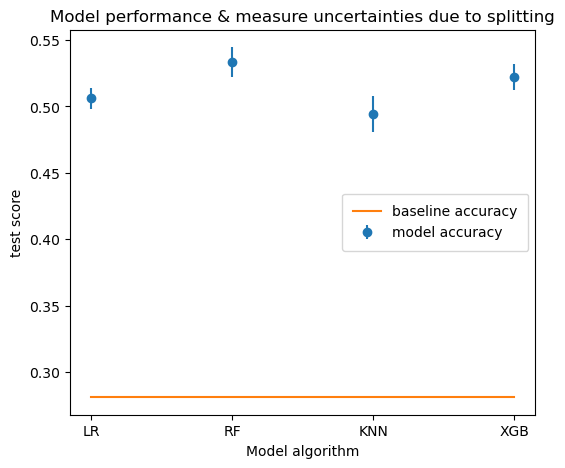

In [20]:
# Measure uncertainties due to splitting
import matplotlib.pylab as plt
model_means = [np.mean(lr[0]),np.mean(rf[0]),np.mean(knn[0]), np.mean(test_scores)]
model_stds = [np.std(lr[0]),np.std(rf[0]),np.std(knn[0]), np.std(test_scores)]
plt.figure(figsize=(6,5))
plt.errorbar(['LR','RF','KNN','XGB'], model_means, yerr=model_stds, fmt='o', label='model accuracy')
plt.plot(['LR','RF','KNN','XGB'], [base_acc] * 4, label='baseline accuracy')
plt.title('Model performance & measure uncertainties due to splitting')
plt.legend(borderpad=0.8)
plt.xlabel('Model algorithm')
plt.ylabel('test score')
plt.savefig('../figures/models_performance.png',dpi=500,bbox_inches="tight")
plt.show()

In [21]:
# # save the best RF model
import pickle
best_index = rf[0].index(max(rf[0]))
best_model = rf[1][best_index]
X_test = rf[2][best_index][0]
y_test = rf[2][best_index][1]
file = open('../results/grid.save', 'wb')
pickle.dump((best_model, X_test, y_test), file)
file.close()

In [22]:
import pickle
file = open('../results/grid.save', 'rb')
best_model, X_test, y_test = pickle.load(file)
file.close()
best_model.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer3',
                                                                   IterativeImputer(estimator=LinearRegression(),
                                                                                    random_state=126)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Work_Experience',
                                                   'Family_Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEnc...
                                                 ('ord',
                                                  Pipeline(steps=[('imputer2',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Low',
                                                                                               'Average',
                                                                                               'High']]))]),
                                                  ['Spending_Score'])])),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, max_features=0.3,
                                        min_samples_leaf=10, n_estimators=170,
                                        random_state=126))])

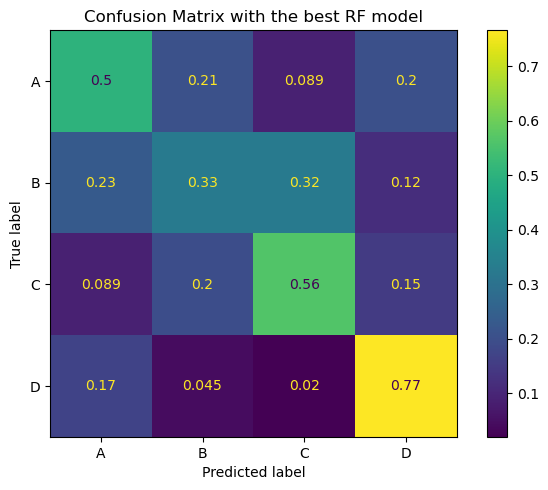

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_true = y_test
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_true,y_pred, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=['A', 'B', 'C', 'D'])
disp.plot()
plt.tight_layout()
plt.title('Confusion Matrix with the best RF model')
plt.savefig('../figures/confusion_matrix_rf.png',dpi=500,bbox_inches="tight")
plt.show()

In [24]:
df_test = best_model.best_estimator_[0].transform(X_test)
df_test = best_model.best_estimator_[1].transform(df_test)
df_test = pd.DataFrame(data=df_test, columns = rf[3])
df_test.head()

,num__Age,num__Work_Experience,num__Family_Size,cat__Gender_Female,cat__Gender_Male,cat__Ever_Married_No,cat__Ever_Married_Yes,cat__Ever_Married_missing,cat__Graduated_No,cat__Graduated_Yes,...,cat__Profession_missing,cat__Var_1_Cat_1,cat__Var_1_Cat_2,cat__Var_1_Cat_3,cat__Var_1_Cat_4,cat__Var_1_Cat_5,cat__Var_1_Cat_6,cat__Var_1_Cat_7,cat__Var_1_missing,ord__Spending_Score
0,0.218665,0.414204,-1.244140,-0.906149,0.906149,1.204270,-1.163142,-0.131068,-0.773253,0.790490,...,-0.122878,-0.12672,-0.231392,-0.342329,-0.396290,-0.103955,0.739080,-0.164974,-0.094395,-0.739651
1,-0.201676,-0.506663,-1.244140,-0.906149,0.906149,1.204270,-1.163142,-0.131068,1.293238,-1.265038,...,-0.122878,-0.12672,-0.231392,-0.342329,2.523406,-0.103955,-1.353034,-0.164974,-0.094395,-0.739651
2,0.218665,-0.813619,-0.571083,1.103571,-1.103571,-0.830379,0.859741,-0.131068,1.293238,-1.265038,...,-0.122878,-0.12672,-0.231392,-0.342329,2.523406,-0.103955,-1.353034,-0.164974,-0.094395,1.949005
3,-1.222505,0.414204,4.140318,-0.906149,0.906149,1.204270,-1.163142,-0.131068,1.293238,-1.265038,...,-0.122878,-0.12672,4.321670,-0.342329,-0.396290,-0.103955,-1.353034,-0.164974,-0.094395,-0.739651
4,-0.021530,-0.506663,-0.571083,-0.906149,0.906149,1.204270,-1.163142,-0.131068,-0.773253,0.790490,...,-0.122878,-0.12672,4.321670,-0.342329,-0.396290,-0.103955,-1.353034,-0.164974,-0.094395,-0.739651


at least three different global feature importances:
different means different models or metrics (mean decrease in impurity, coefficients)?

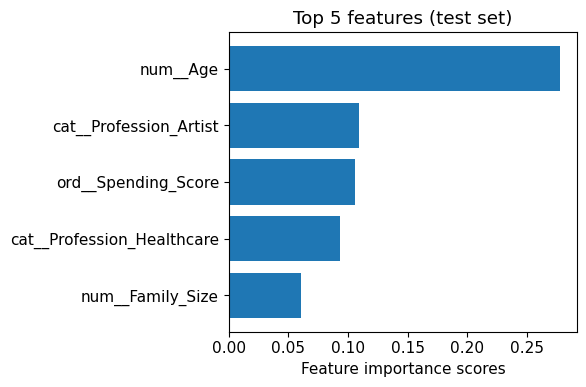

In [25]:
# Feature importance scores from the RF model
forest = best_model.best_estimator_[2]
importances = forest.feature_importances_
sorted_indcs = np.argsort(importances)

plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(6,4))
plt.barh(np.arange(5), importances[sorted_indcs][-5:])
plt.yticks(np.arange(5), rf[3][sorted_indcs][-5:])
plt.title("Top 5 features (test set)")
plt.xlabel('Feature importance scores')
plt.savefig('../figures/global_feature_importance1.png',dpi=500,bbox_inches="tight")
plt.tight_layout()
plt.show()

In [26]:
# Feature importance based on feature permutation
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, df_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=rf[3])

/opt/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.11/site-p

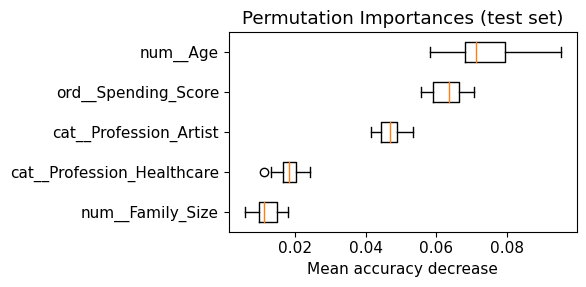

In [27]:
sorted_indcs = np.argsort(forest_importances)
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(6,3))
plt.boxplot(result.importances[sorted_indcs][-5:].T,labels=rf[3][sorted_indcs][-5:],vert=False)
plt.title("Permutation Importances (test set)")
plt.xlabel('Mean accuracy decrease')
plt.savefig('../figures/global_feature_importance2.png',dpi=500,bbox_inches="tight")
plt.tight_layout()
plt.show()

Which features are the most and least important?

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


The figure layout has changed to tight


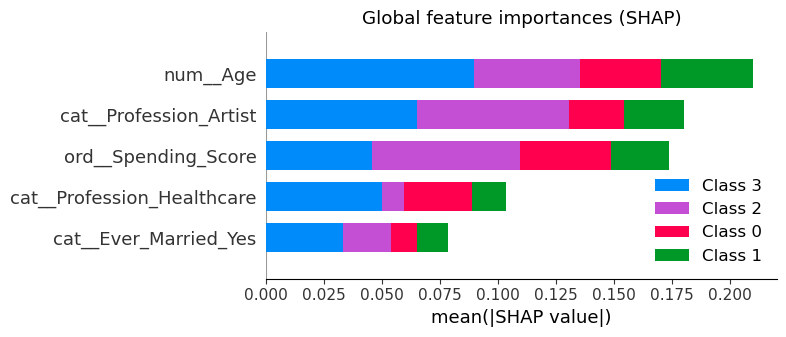

In [28]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(df_test[:1000])
shap.summary_plot(shap_values, df_test[:1000], feature_names = rf[3], max_display=5, show=False)
plt.gcf()
plt.xlabel('mean(|SHAP value|)')
plt.title('Global feature importances (SHAP)')
plt.tight_layout()
plt.savefig('../figures/shap_value.png', dpi=500)
plt.show()

In [29]:
y_test.iloc[0]

'A'

0.24376127891503674


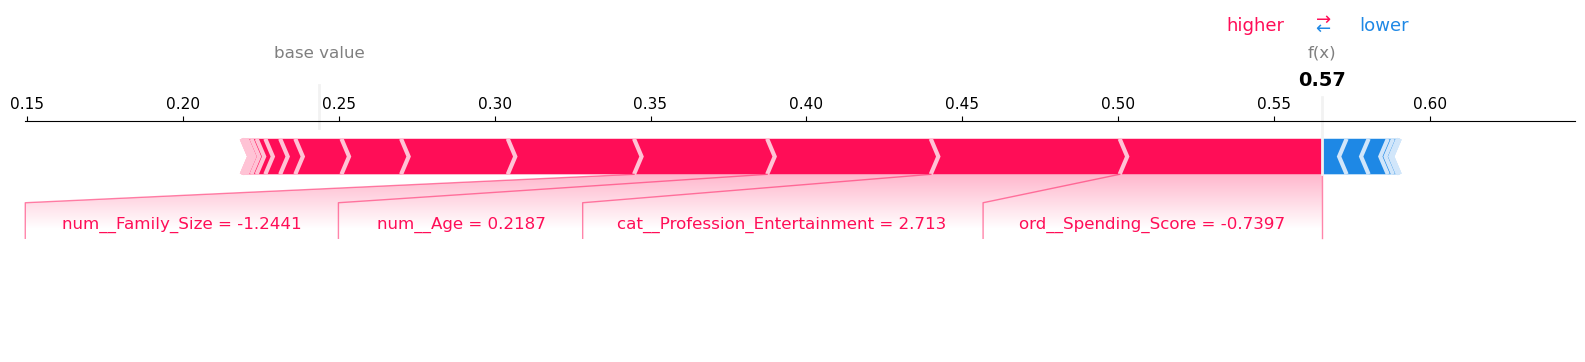

In [30]:
# SHAP values for local feature importance
import shap
shap.initjs() # required for visualizations later on
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(df_test[:1000])
index = 0 # the index of the point to explain
print(explainer.expected_value[0]) # we explain class 0 predictions, true label: A, predicted result: A
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = round(df_test.iloc[index,:], 4),feature_names = rf[3], contribution_threshold=0.14, matplotlib=True, show=False)
plt.savefig('../figures/shap_A.png', dpi=500, bbox_inches='tight')
plt.show()

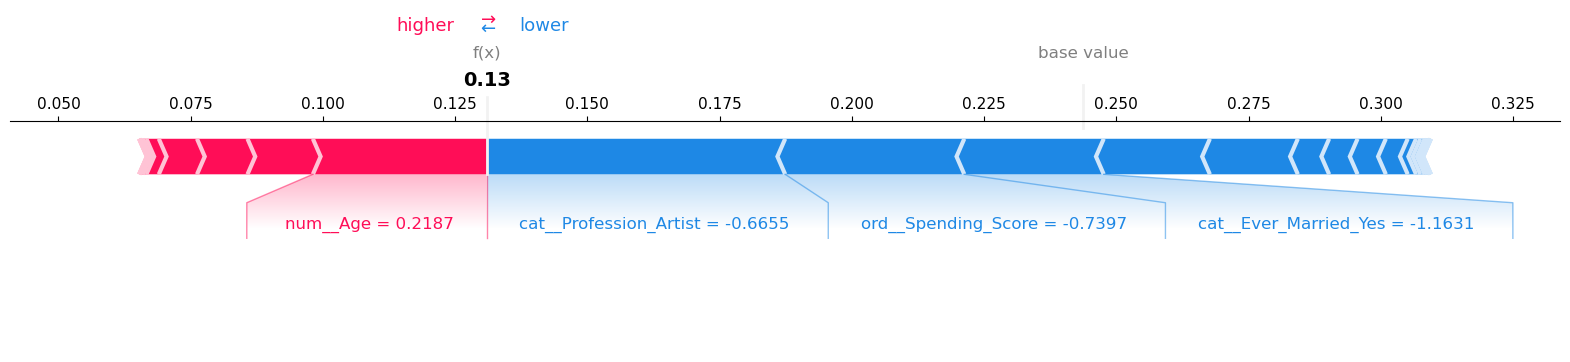

In [31]:
# shap.force_plot(explainer.expected_value[0], shap_values[1][index,:], features = df_test.iloc[index,:],feature_names = rf[3])
shap.force_plot(explainer.expected_value[0], shap_values[1][index,:], features = round(df_test.iloc[index,:], 4),feature_names = rf[3], contribution_threshold=0.12, matplotlib=True, show=False)
plt.savefig('../figures/shap_B.png', dpi=500, bbox_inches='tight')
plt.show() # Data at index 0: Local feature importances (B)

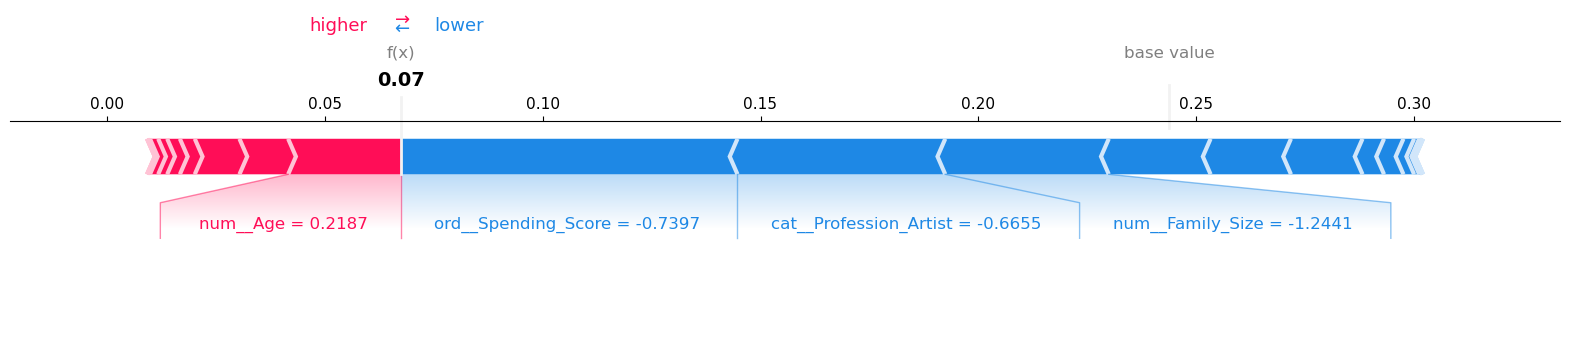

In [32]:
# shap.force_plot(explainer.expected_value[0], shap_values[2][index,:], features = df_test.iloc[index,:],feature_names = rf[3])
shap.force_plot(explainer.expected_value[0], shap_values[2][index,:], features = round(df_test.iloc[index,:], 4),feature_names = rf[3], contribution_threshold=0.12, matplotlib=True, show=False)
plt.savefig('../figures/shap_C.png', dpi=500, bbox_inches='tight')
plt.show() # Data at index 0: Local feature importances (C)

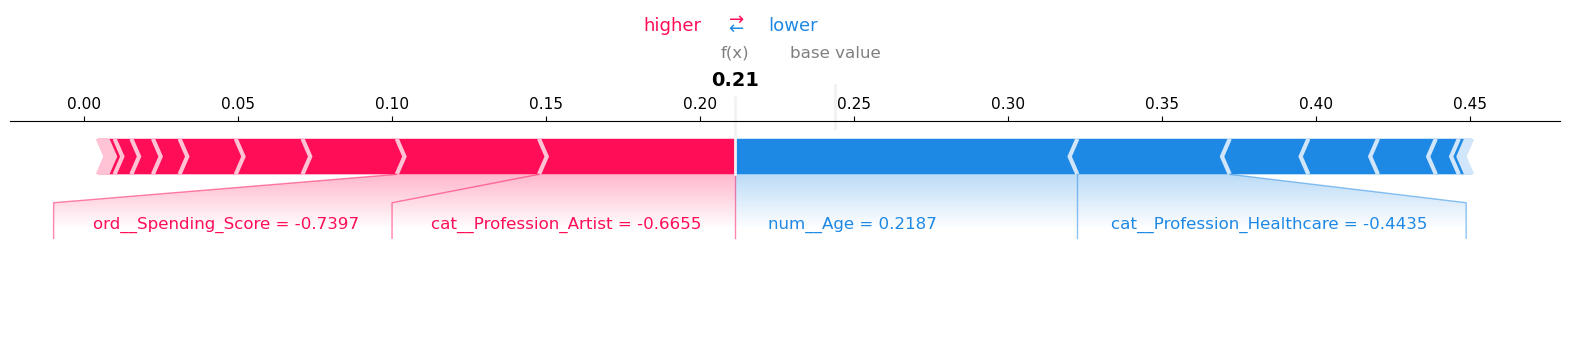

In [33]:
# shap.force_plot(explainer.expected_value[0], shap_values[3][index,:], features = df_test.iloc[index,:],feature_names = rf[3])
shap.force_plot(explainer.expected_value[0], shap_values[3][index,:], features = round(df_test.iloc[index,:], 4),feature_names = rf[3], contribution_threshold=0.12, matplotlib=True, show=False)
plt.savefig('../figures/shap_D.png', dpi=500, bbox_inches='tight')
plt.show() # Data at index 0: Local feature importances (D)